## Assembling a Feature Engineering Pipeline with Feature-engine and Cross-validation

[Feature Engineering for Machine Learning Course](https://www.trainindata.com/p/feature-engineering-for-machine-learning)

In this notebook, I will show you how to use Feature-engine within the Scikit-learn pipeline, utilizing cross-validation. 

I will:
- build a gradient boosted tree
- use feature-engine for the feature engineering steps
- set up an entire engineering and prediction pipeline using a Scikit-learn Pipeline
- train the pipeline with cross-validation, looking over different feature-engineering parameters

============================================================================

## In this demo:

We will use the titanic dataset, please refer to lecture **Datasets** in Section 1 of the course for instructions on how to download and prepare this dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for the model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

# for feature engineering
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce

In [2]:
# load dataset

cols = [
    'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'cabin',
    'embarked', 'survived'
]

data = pd.read_csv('../Datasets/titanic.csv', usecols=cols)

data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked
0,1,1,female,29.0000,0,0,211.3375,B5,S
1,1,1,male,0.9167,1,2,151.5500,C22,S
2,1,0,female,2.0000,1,2,151.5500,C22,S
3,1,0,male,30.0000,1,2,151.5500,C22,S
4,1,0,female,25.0000,1,2,151.5500,C22,S


In [3]:
# Cabin: extract numerical and categorical part and delete original variable

data['cabin_num'] = data['cabin'].str.extract('(\d+)') # captures numerical part
data['cabin_num'] = data['cabin_num'].astype('float')
data['cabin_cat'] = data['cabin'].str[0] # captures the first letter

data.drop(['cabin'], axis=1, inplace=True)

In [4]:
# make list of variables types

# numerical: discrete and continuous
discrete = [
    var for var in data.columns if data[var].dtype != 'O' and var != 'survived'
    and data[var].nunique() < 10
]
continuous = [
    var for var in data.columns
    if data[var].dtype != 'O' and var != 'survived' and var not in discrete
]

# categorical
categorical = [var for var in data.columns if data[var].dtype == 'O']

print('There are {} discrete variables'.format(len(discrete)))
print('There are {} continuous variables'.format(len(continuous)))
print('There are {} categorical variables'.format(len(categorical)))

There are 3 discrete variables
There are 3 continuous variables
There are 3 categorical variables


In [5]:
# separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.1,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1178, 9), (131, 9))

### Set up the pipeline

In [7]:
titanic_pipe = Pipeline([

    # missing data imputation - section 4
    ('imputer_num',
     mdi.ArbitraryNumberImputer(arbitrary_number=-1,
                                variables=['age', 'fare', 'cabin_num'])),
    ('imputer_cat',
     mdi.CategoricalImputer(variables=['embarked', 'cabin_cat'])),

    # categorical encoding - section 6
    ('encoder_rare_label',
     ce.RareLabelEncoder(tol=0.01,
                                    n_categories=2,
                                    variables=['embarked', 'cabin_cat'])),
    ('categorical_encoder',
     ce.OrdinalEncoder(encoding_method='ordered',
                                  variables=['cabin_cat', 'sex', 'embarked'])),

    # # Gradient Boosted machine
    # ('gbm', GradientBoostingClassifier(random_state=0))
    # xgboost model
    ('xgb', XGBClassifier(random_state=0))
])

## Set up the Grid ad the cross-validation strategy

In [10]:
# now we create the grid with all the parameters that we would like to test

param_grid = {
    # try different feature engineering parameters
    'imputer_num__arbitrary_number': [-1, 99],
    'encoder_rare_label__tol': [0.1, 0.2],
    'categorical_encoder__encoding_method': ['ordered', 'arbitrary'],
    
    # try different gradient boosted tree model paramenters
    # 'gbm__max_depth': [None, 1, 3],
    'xgb__max_depth': [None, 1, 3],
}


# now we set up the grid search with cross-validation
grid_search = GridSearchCV(titanic_pipe, param_grid,
                           cv=5, n_jobs=-1, scoring='roc_auc')

# cv=5 is the cross-validation steps
# no_jobs =-1 indicates to use all available cpus
# scoring='roc-auc' indicates to evaluate the model performance with the roc-auc

# for more details in the grid parameters visit:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [11]:
# and now we train over all the possible combinations of the parameters above
grid_search.fit(X_train, y_train)

# and we print the best score over the train set
print(("best roc-auc from grid search: %.3f"
       % grid_search.score(X_train, y_train)))

best roc-auc from grid search: 0.957


In [12]:
# we can print the best estimator parameters like this
grid_search.best_estimator_

Pipeline(steps=[('imputer_num',
                 ArbitraryNumberImputer(arbitrary_number=-1,
                                        variables=['age', 'fare',
                                                   'cabin_num'])),
                ('imputer_cat',
                 CategoricalImputer(variables=['embarked', 'cabin_cat'])),
                ('encoder_rare_label',
                 RareLabelEncoder(n_categories=2, tol=0.1,
                                  variables=['embarked', 'cabin_cat'])),
                ('categorical_encoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                v...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=0, ...))])

In [13]:
# and find the best fit parameters like this
grid_search.best_params_

{'categorical_encoder__encoding_method': 'arbitrary',
 'encoder_rare_label__tol': 0.1,
 'imputer_num__arbitrary_number': -1,
 'xgb__max_depth': 3}

In [14]:
# here we can see all the combinations evaluated during the gridsearch
grid_search.cv_results_['params']

[{'categorical_encoder__encoding_method': 'ordered',
  'encoder_rare_label__tol': 0.1,
  'imputer_num__arbitrary_number': -1,
  'xgb__max_depth': None},
 {'categorical_encoder__encoding_method': 'ordered',
  'encoder_rare_label__tol': 0.1,
  'imputer_num__arbitrary_number': -1,
  'xgb__max_depth': 1},
 {'categorical_encoder__encoding_method': 'ordered',
  'encoder_rare_label__tol': 0.1,
  'imputer_num__arbitrary_number': -1,
  'xgb__max_depth': 3},
 {'categorical_encoder__encoding_method': 'ordered',
  'encoder_rare_label__tol': 0.1,
  'imputer_num__arbitrary_number': 99,
  'xgb__max_depth': None},
 {'categorical_encoder__encoding_method': 'ordered',
  'encoder_rare_label__tol': 0.1,
  'imputer_num__arbitrary_number': 99,
  'xgb__max_depth': 1},
 {'categorical_encoder__encoding_method': 'ordered',
  'encoder_rare_label__tol': 0.1,
  'imputer_num__arbitrary_number': 99,
  'xgb__max_depth': 3},
 {'categorical_encoder__encoding_method': 'ordered',
  'encoder_rare_label__tol': 0.2,
  'impu

In [15]:
# and here the scores for each of one of the above combinations
grid_search.cv_results_['mean_test_score']

array([0.85094238, 0.84513587, 0.86272557, 0.84883389, 0.84893065,
       0.8647856 , 0.8500748 , 0.84489234, 0.86270274, 0.84785216,
       0.84853492, 0.86641422, 0.84917754, 0.84486169, 0.8670825 ,
       0.85163292, 0.84829981, 0.86572376, 0.84890357, 0.84486169,
       0.8658344 , 0.85101648, 0.84829981, 0.86535085])

In [16]:
# and finally let's check the performance over the test set
print(("best linear regression from grid search: %.3f"
       % grid_search.score(X_test, y_test)))

best linear regression from grid search: 0.852


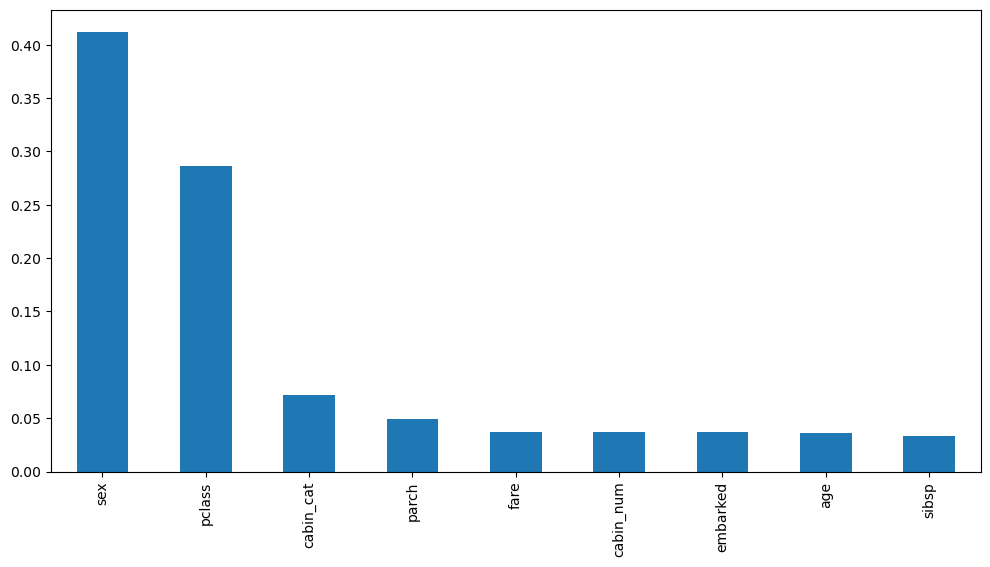

In [18]:
# let's explore the importance of the features

importance = pd.Series(grid_search.best_estimator_['xgb'].feature_importances_)
importance.index = data.drop('survived', axis=1).columns
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(12,6));